In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.3)  

train_gen = augs.flow_from_directory(
    '../input/cell_images/cell_images',
    target_size = (50,50),
    batch_size=16,
    class_mode = 'categorical',
    subset='training')

val_gen = augs.flow_from_directory(
    '../input/cell_images/cell_images',
    target_size=(50,50),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [4]:
def ConvBlock(model, layers, filters,name):
    for i in range(layers):
        model.add(SeparableConv2D(filters, (3, 3), activation='relu',name=name))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(50, 50, 3)))
    ConvBlock(model, 1, 64,'block_1')
    ConvBlock(model, 1, 128,'block_2')
    ConvBlock(model, 1, 256,'block_3')
    ConvBlock(model, 1, 512,'block_4')
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='sigmoid'))
    return model

model = FCN()
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 50, 50, 3)         0         
_________________________________________________________________
block_1 (SeparableConv2D)    (None, 48, 48, 64)        283       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
block_2 (SeparableConv2D)    (None, 22, 22, 128)       8896      
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
__________

In [5]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [6]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 1206, 
    validation_data  = val_gen,
    validation_steps = 1206,
    epochs = 10, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/10
1206/1206 [==============================] - 124s 103ms/step - loss: 0.3879 - acc: 0.8221 - val_loss: 0.2085 - val_acc: 0.9277

Epoch 00001: val_loss improved from inf to 0.20853, saving model to ./base.model
Epoch 2/10
1206/1206 [==============================] - 93s 77ms/step - loss: 0.2049 - acc: 0.9296 - val_loss: 0.1643 - val_acc: 0.9439

Epoch 00002: val_loss improved from 0.20853 to 0.16433, saving model to ./base.model
Epoch 3/10
1206/1206 [==============================] - 92s 77ms/step - loss: 0.1831 - acc: 0.9383 - val_loss: 0.1645 - val_acc: 0.9466

Epoch 00003: val_loss did not improve from 0.16433
Epoch 4/10
1206/1206 [==============================] - 93s 77ms/step - loss: 0.1815 - acc: 0.9393 - val_loss: 0.1467 - val_acc: 0.9478

Epoch 00004: val_loss improved from 0.16433 to 0.14673, saving model to ./base.model
Epoch 5/10
1206/1206 [==============================] - 93s 77ms/step - loss: 0.1680 - acc: 0.9433 - val_loss: 0.1488 - val_acc: 0.9492

Epoch 00005

Model Test Loss: 0.14358350084569532
Model Test Accuracy: 0.9510646019984527


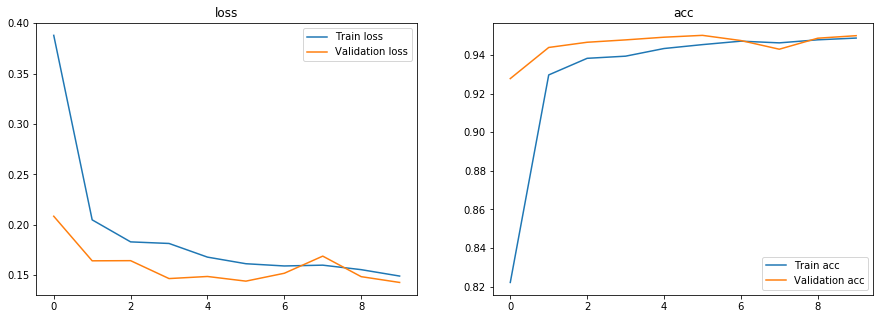

In [7]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(val_gen)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])


In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-02-16 23:13:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.237.103, 3.92.108.98, 34.232.40.183, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.237.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.74MB/s    in 0.5s    

2019-02-16 23:13:09 (9.74 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://978019cd.ngrok.io
